# Projet 07 : Effectuer une prédiction de revenus

---

## <font color=blue>Sommaire</font>

[1. Exploration des données utilisées (notebook séparé)](data_analyst_projet07_M1_M2_analyse.ipynb)  
  
[2. Concentration des revenus (notebook séparé)](data_analyst_projet07_M1_M2_analyse.ipynb)  
  
[3. Echantillonnage des individus](#3_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1. Préparation des coefficients d'élasticité](#3_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2. Génération des variables ln_y_parents, residus et y_child](#3_2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.3. Génération des classes de revenus et des probabilités conditionnelles](#3_3)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.4. Graphiques de vérification des probabilités conditionnelles](#3_4)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.5. Génération de l'échantillon d'individus](#3_5)  

[4. Modélisation du revenu des individus (notebook séparé)](data_analyst_projet07_M4_preparation_donnees.ipynb)

---
**Importation des librairies**

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
#import warnings
#warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf

from itertools import compress
#import joblib

import sf_graphiques as sfg
#import sf_stats_inferentielles as sfsi
#import sf_classification_acp as sfca

import sf_modeles_regression as sfmr
#import sf_modeles_classif_supervisee as sfmcs

<a id='3_0'></a>

---
## <font color=blue> Mission 3 : Echantillonnage des individus <font>

### 3.1. Préparation des coefficients d'élasticité

In [4]:
igm = pd.read_csv("GDIMMay2018.csv")
igm.head()

,countryname,wbcode,iso3,region,incgroup2,incgroup4,fragile,survey,year,status,...,Cores2125_MAcatC1,Shortfall0611_obs,Shortfall0611_IGP,Shortfall1217_obs,Shortfall1217_IGP,IGEincome,S1,S2,S3,MLD_psu
0,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,25103.0,0.086197,18054.0,0.345224,NaN,NaN,NaN,NaN,0.1
1,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12107.0,0.083271,8538.0,0.389952,NaN,NaN,NaN,NaN,0.1
2,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12996.0,0.089161,9516.0,0.307687,NaN,NaN,NaN,NaN,0.1
3,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,25396.0,0.050447,18387.0,0.218062,NaN,NaN,NaN,NaN,0.1
4,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12246.0,0.047961,8677.0,0.230909,NaN,NaN,NaN,NaN,0.1


Je constate que la variable IGEincome n'est pas renseignée dans les 5 premières lignes. Je regarde le nombre de lignes puis le nombre de pays avec l'information sur le coefficient d'élasticité.

In [5]:
igm[["iso3","IGEincome"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6504 entries, 0 to 6503
Data columns (total 2 columns):
iso3         6504 non-null object
IGEincome    853 non-null float64
dtypes: float64(1), object(1)
memory usage: 101.7+ KB


In [6]:
igm[["iso3","IGEincome"]].groupby("iso3").mean().info()

<class 'pandas.core.frame.DataFrame'>
Index: 150 entries, AFG to ZMB
Data columns (total 1 columns):
IGEincome    75 non-null float64
dtypes: float64(1)
memory usage: 2.3+ KB


853 lignes, sur un total de 6504, comprennent des données pour la variable IGEincome. Sur 150 pays en base, 75 pays ont au moins une information sur le coefficient d'élasticité.  
Je remarque qu'il y a plusieurs lignes pour un pays. Afin de mieux saisir le fonctionnement du fichier, je l'analyse pour un pays donné, par exemple la France, en séparant les lignes qui comprennent une information sur le coefficient d'élasticité des autres lignes.

In [7]:
igm[igm.iso3=="FRA"].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 1884 to 1943
Data columns (total 66 columns):
countryname          60 non-null object
wbcode               60 non-null object
iso3                 60 non-null object
region               60 non-null object
incgroup2            60 non-null object
incgroup4            60 non-null object
fragile              60 non-null int64
survey               60 non-null object
year                 60 non-null int64
status               60 non-null object
cohort               60 non-null int64
parent               60 non-null object
child                60 non-null object
obs                  60 non-null float64
P1                   60 non-null float64
P2                   60 non-null float64
P3                   60 non-null float64
P4                   60 non-null float64
P5                   60 non-null float64
C1                   60 non-null float64
C2                   60 non-null float64
C3                   60 non-null float64
C4    

In [8]:
igm[(igm.iso3=="FRA") & (igm.IGEincome.isna())].T

,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,...,1934,1935,1936,1937,1938,1939,1940,1941,1942,1943
countryname,France,France,France,France,France,France,France,France,France,France,...,France,France,France,France,France,France,France,France,France,France
wbcode,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,...,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA
iso3,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,...,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA
region,High income,High income,High income,High income,High income,High income,High income,High income,High income,High income,...,High income,High income,High income,High income,High income,High income,High income,High income,High income,High income
incgroup2,High-income economies,High-income economies,High-income economies,High-income economies,High-income economies,High-income economies,High-income economies,High-income economies,High-income economies,High-income economies,...,High-income economies,High-income economies,High-income economies,High-income economies,High-income economies,High-income economies,High-income economies,High-income economies,High-income economies,High-income economies
incgroup4,High income,High income,High income,High income,High income,High income,High income,High income,High income,High income,...,High income,High income,High income,High income,High income,High income,High income,High income,High income,High income
fragile,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
survey,ESS,ESS,ESS,ESS,ESS,ESS,ESS,ESS,ESS,ESS,...,ESS,ESS,ESS,ESS,ESS,ESS,ESS,ESS,ESS,ESS
year,1940,1940,1940,1940,1940,1940,1940,1940,1940,1940,...,1980,1980,1980,1980,1980,1980,1980,1980,1980,1980
status,Retrospective question,Retrospective question,Retrospective question,Retrospective question,Retrospective question,Retrospective question,Retrospective question,Retrospective question,Retrospective question,Retrospective question,...,Retrospective question,Retrospective question,Retrospective question,Retrospective question,Retrospective question,Retrospective question,Retrospective question,Retrospective question,Retrospective question,Retrospective question


In [9]:
igm[(igm.iso3=="FRA") & (~igm.IGEincome.isna())].T

,1908,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919
countryname,France,France,France,France,France,France,France,France,France,France,France,France
wbcode,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA
iso3,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA,FRA
region,High income,High income,High income,High income,High income,High income,High income,High income,High income,High income,High income,High income
incgroup2,High-income economies,High-income economies,High-income economies,High-income economies,High-income economies,High-income economies,High-income economies,High-income economies,High-income economies,High-income economies,High-income economies,High-income economies
incgroup4,High income,High income,High income,High income,High income,High income,High income,High income,High income,High income,High income,High income
fragile,0,0,0,0,0,0,0,0,0,0,0,0
survey,ESS,ESS,ESS,ESS,ESS,ESS,ESS,ESS,ESS,ESS,ESS,ESS
year,1960,1960,1960,1960,1960,1960,1960,1960,1960,1960,1960,1960
status,Retrospective question,Retrospective question,Retrospective question,Retrospective question,Retrospective question,Retrospective question,Retrospective question,Retrospective question,Retrospective question,Retrospective question,Retrospective question,Retrospective question


In [10]:
igm.IGEincome.nunique()

75

In [11]:
igm[igm.cohort!=igm.year]

,countryname,wbcode,iso3,region,incgroup2,incgroup4,fragile,survey,year,status,...,Cores2125_MAcatC1,Shortfall0611_obs,Shortfall0611_IGP,Shortfall1217_obs,Shortfall1217_IGP,IGEincome,S1,S2,S3,MLD_psu


**Premières constatations**

Mes constatations issues des vues ci-dessus et de la lecture de la documentation sur la base GDIM :  
- les variables year et cohort sont identiques. Elles indiquent la décennie de naissance des individus étudiés (décennie de naissance des enfants) ;  
- les lignes avec et sans l'IGEincome ne sont pas redondantes. Les chiffres de la base concernent à la fois la persistance du niveau d'éducation d'une génération à l'autre et le coefficient d'élasticité des revenus (persistance des revenus d'une génération à l'autre). Les chiffres sur les études sont disponibles pour un plus grand nombre de décennies de naissance, ce qui explique les nombreuses lignes sans information sur le coefficient d'élasticité des revenus (qui ne semble disponible que pour une décennie de naissance) ;  
- pour une même décennie de naissance, les informations sont divisées par catégorie parent et child pour une analyse plus poussée de la persistance du niveau d'étude entre enfants et parents (coefficient de persistance IGP et coefficient de corrélation entre les années d'étude COR). Les informations dans ce domaine sont plus poussées avec les chiffres globaux (les 2 parents vers tous leurs enfants) et détaillés par sous-catégorie (père ou mère ou niveau maximum d'étude des 2 vers fils ou filles). Par contre, toutes les lignes contiennent le même coefficient d'élasticité pour un pays et une décennie de naissance donnée : 75 valeurs uniques différentes pour le coefficient d'élasticité des revenus, comme le nombre de pays avec l'information sur le coefficient d'élasticité des revenus. Je peux donc faire la moyenne de toutes les lignes avec la variable IGEincome non nulle.

In [12]:
elasticite = igm[~igm.IGEincome.isna()][["iso3","countryname","cohort","IGEincome","region"]].groupby(["region","iso3","countryname","cohort"]).mean().reset_index()
elasticite.columns = ["region","country_code","country_name","decennie_etudiee","coef_elasticite"]
elasticite.set_index("country_code", inplace=True)
elasticite = elasticite[["country_name","decennie_etudiee","coef_elasticite","region"]]
elasticite.head()

,country_name,decennie_etudiee,coef_elasticite,region
country_code,,,,
CHN,China,1960,0.399000,East Asia & Pacific
MNG,Mongolia,1970,0.401002,East Asia & Pacific
MYS,Malaysia,1960,0.540000,East Asia & Pacific
TLS,Timor-Leste,1970,0.701994,East Asia & Pacific
VNM,Vietnam,1960,0.480000,East Asia & Pacific


In [13]:
len(elasticite)

75

Pour les pays sans information sur le coefficient d'élasticité des revenus dans la base GDIM, j'ajoute une estimation sur la base des moyennes disponibles par région dans le fichier 'elasticity.txt'.  
Ce fichier comporte le tableau suivant :  
  
Area | Base case | Optimistic (high mobility) | Pessimistic (low mobility)  
:-: | :-: | :-: | :-:  
Nordic European countries and Canada | 0.2 | 0.15 | 0.3  
Europe (except nordic countries) | 0.4 | 0.3 | 0.5  
Australia/New Zealand/USA | 0.4 | 0.3 | 0.5  
Asia | 0.5 | 0.4 | 0.6  
Latin America/Africa | 0.66 | 0.5 | 0.9  
  


Je vérifie la correspondance des valeurs entre la base GDIM et le fichier elasticity.txt

Je crée deux dataframes, l'un avec les pays pour lesquels je dispose de l'information sur l'IGEincome, l'autre avec les pays pour lesquels je ne dispose pas de l'information sur l'IGEincome.  Ces dataframes comprennent la région définie dans la base GDIM, le code pays iso3, le nom du pays, les valeurs IGP (et IGEincome si dispo).  
J'ajoute une colonne area qui correspond aux régions du fichier 'elasticity.txt'.

**Création du dataframe countries_with_ide et définition de la colonne area**

In [14]:
countries_with_ige = igm[~igm.IGEincome.isna()][["iso3","IGP","IGEincome","region","countryname"]].groupby(["region","iso3","countryname"]).mean().reset_index()
print(len(countries_with_ige))
countries_with_ige.head()

75


,region,iso3,countryname,IGP,IGEincome
0,East Asia & Pacific,CHN,China,0.367084,0.399000
1,East Asia & Pacific,MNG,Mongolia,0.150777,0.401002
2,East Asia & Pacific,MYS,Malaysia,0.379392,0.540000
3,East Asia & Pacific,TLS,Timor-Leste,0.866754,0.701994
4,East Asia & Pacific,VNM,Vietnam,0.417062,0.480000


In [15]:
list_regions = countries_with_ige.region.unique()
print(len(list_regions))
list_regions

7


array(['East Asia & Pacific', 'Europe & Central Asia', 'High income',
       'Latin America & Caribbean', 'Middle East & North Africa',
       'South Asia', 'Sub-Saharan Africa'], dtype=object)

In [16]:
inter0 = countries_with_ige[countries_with_ige.region==list_regions[0]].copy()
inter0

,region,iso3,countryname,IGP,IGEincome
0,East Asia & Pacific,CHN,China,0.367084,0.399000
1,East Asia & Pacific,MNG,Mongolia,0.150777,0.401002
2,East Asia & Pacific,MYS,Malaysia,0.379392,0.540000
3,East Asia & Pacific,TLS,Timor-Leste,0.866754,0.701994
4,East Asia & Pacific,VNM,Vietnam,0.417062,0.480000


In [17]:
elasticity_region = inter0[["iso3"]].copy()
elasticity_region["area"] = "Asia"

In [18]:
inter1 = countries_with_ige[countries_with_ige.region==list_regions[1]].copy()
inter1

,region,iso3,countryname,IGP,IGEincome
5,Europe & Central Asia,ALB,Albania,0.456693,0.815874
6,Europe & Central Asia,BIH,Bosnia and Herzegovina,0.450864,0.827252
7,Europe & Central Asia,BLR,Belarus,0.252845,0.342738
8,Europe & Central Asia,KAZ,Kazakhstan,0.307301,0.237995
9,Europe & Central Asia,KGZ,Kyrgyz Republic,0.229695,0.352871
10,Europe & Central Asia,MKD,"Macedonia, FYR",0.630283,0.416638
11,Europe & Central Asia,ROU,Romania,0.518373,0.369699
12,Europe & Central Asia,RUS,Russian Federation,0.159921,0.330000
13,Europe & Central Asia,UZB,Uzbekistan,0.108527,0.496764


In [19]:
inter11 = inter1.loc[[5,6,7,10,11]].copy()
print(inter11.countryname.values)  #verif
inter_elast = inter11[["iso3"]].copy()
inter_elast["area"] = "Europe"
elasticity_region = elasticity_region.append(inter_elast)

['Albania' 'Bosnia and Herzegovina' 'Belarus' 'Macedonia, FYR' 'Romania']


In [20]:
inter12 = inter1.loc[[8,9,12,13]].copy()
print(inter12.countryname.values)  #verif
inter_elast = inter12[["iso3"]].copy()
inter_elast["area"] = "Asia"
elasticity_region = elasticity_region.append(inter_elast)

['Kazakhstan' 'Kyrgyz Republic' 'Russian Federation' 'Uzbekistan']


In [21]:
print("Verif nombre pays : {}".format(len(inter1) == len(inter11) + len(inter12)))

Verif nombre pays : True


In [22]:
inter2 = countries_with_ige[countries_with_ige.region==list_regions[2]]
inter2

,region,iso3,countryname,IGP,IGEincome
14,High income,AUS,Australia,0.202700,0.275000
15,High income,AUT,Austria,0.437402,0.245267
16,High income,BEL,Belgium,0.322624,0.183176
17,High income,CAN,Canada,0.190509,0.269333
18,High income,CHE,Switzerland,0.270725,0.254594
19,High income,CHL,Chile,0.416113,0.570000
20,High income,CYP,Cyprus,0.329275,0.342000
21,High income,CZE,Czech Republic,0.345548,0.434041
22,High income,DEU,Germany,0.419467,0.237904
23,High income,DNK,Denmark,0.326534,0.145146


In [23]:
inter21 = inter2.loc[[14,38,45]].copy()
print(inter21.countryname.values)  #verif
inter_elast = inter21[["iso3"]].copy()
inter_elast["area"] = "Australia_NZ_USA"
elasticity_region = elasticity_region.append(inter_elast)

['Australia' 'New Zealand' 'United States']


In [24]:
inter22 = inter2.loc[[15,16,18,20,21,22,24,26,27,28,29,30,31,34,35,36,39,41,42]].copy()
print(inter22.countryname.values)  #verif
inter_elast = inter22[["iso3"]].copy()
inter_elast["area"] = "Europe"
elasticity_region = elasticity_region.append(inter_elast)

['Austria' 'Belgium' 'Switzerland' 'Cyprus' 'Czech Republic' 'Germany'
 'Spain' 'France' 'United Kingdom' 'Greece' 'Croatia' 'Ireland' 'Italy'
 'Luxembourg' 'Latvia' 'Netherlands' 'Portugal' 'Slovak Republic'
 'Slovenia']


In [25]:
inter23 = inter2.loc[[17,23,25,37,43]].copy()
print(inter23.countryname.values)  #verif
inter_elast = inter23[["iso3"]].copy()
inter_elast["area"] = "Canada-Nordic_Europe"
elasticity_region = elasticity_region.append(inter_elast)

['Canada' 'Denmark' 'Finland' 'Norway' 'Sweden']


In [26]:
inter24 = inter2.loc[19].copy()
print(inter24.countryname)  #verif
inter_elast = inter24[["iso3"]].copy()
inter_elast["area"] = "Latin_America-Africa"
elasticity_region = elasticity_region.append(inter_elast)

Chile


In [27]:
inter25 = inter2.loc[[32,33,40,44]].copy()
print(inter25.countryname.values)  #verif
inter_elast = inter25[["iso3"]].copy()
inter_elast["area"] = "Asia"
elasticity_region = elasticity_region.append(inter_elast)

['Japan' 'Korea, Rep.' 'Singapore' 'Taiwan, China']


In [28]:
print("Verif nombre pays : {}".format(len(inter2) == len(inter21) + len(inter22) + len(inter23) + 1 + len(inter25)))

Verif nombre pays : True


In [29]:
inter3 = countries_with_ige[countries_with_ige.region==list_regions[3]]
inter3

,region,iso3,countryname,IGP,IGEincome
46,Latin America & Caribbean,BOL,Bolivia,0.623477,0.866268
47,Latin America & Caribbean,BRA,Brazil,0.554925,0.635000
48,Latin America & Caribbean,COL,Colombia,0.604599,1.095440
49,Latin America & Caribbean,ECU,Ecuador,0.576339,1.029957
50,Latin America & Caribbean,GTM,Guatemala,0.838418,1.015206
51,Latin America & Caribbean,PAN,Panama,0.549463,0.966865
52,Latin America & Caribbean,PER,Peru,0.635211,0.667000


In [30]:
inter_elast = inter3[["iso3"]].copy()
inter_elast["area"] = "Latin_America-Africa"
elasticity_region = elasticity_region.append(inter_elast)

In [31]:
inter4 = countries_with_ige[countries_with_ige.region==list_regions[4]]
inter4

,region,iso3,countryname,IGP,IGEincome
53,Middle East & North Africa,EGY,"Egypt, Arab Rep.",0.501950,0.943205
54,Middle East & North Africa,JOR,Jordan,0.278984,0.517398
55,Middle East & North Africa,MAR,Morocco,0.626294,0.945744
56,Middle East & North Africa,TUN,Tunisia,0.552685,0.860433


In [32]:
inter41 = inter4.loc[54].copy()
print(inter41.countryname)  #verif
inter_elast = inter41[["iso3"]].copy()
inter_elast["area"] = "Asia"
elasticity_region = elasticity_region.append(inter_elast)

Jordan


In [33]:
inter42 = inter4.loc[[53,55,56]].copy()
print(inter42.countryname.values)  #verif
inter_elast = inter42[["iso3"]].copy()
inter_elast["area"] = "Latin_America-Africa"
elasticity_region = elasticity_region.append(inter_elast)

['Egypt, Arab Rep.' 'Morocco' 'Tunisia']


In [34]:
print("Verif nombre pays : {}".format(len(inter4) == 1 + len(inter42)))

Verif nombre pays : True


In [35]:
inter5 = countries_with_ige[countries_with_ige.region==list_regions[5]]
inter5

,region,iso3,countryname,IGP,IGEincome
57,South Asia,BGD,Bangladesh,NaN,0.5380
58,South Asia,IND,India,0.793539,0.5960
59,South Asia,NPL,Nepal,0.810220,0.4360
60,South Asia,PAK,Pakistan,0.762066,0.4505


In [36]:
inter_elast = inter5[["iso3"]].copy()
inter_elast["area"] = "Asia"
elasticity_region = elasticity_region.append(inter_elast)

In [37]:
inter6 = countries_with_ige[countries_with_ige.region==list_regions[6]]
inter6

,region,iso3,countryname,IGP,IGEincome
61,Sub-Saharan Africa,BEN,Benin,0.703738,0.855116
62,Sub-Saharan Africa,COD,"Congo, Dem. Rep.",0.440542,0.707703
63,Sub-Saharan Africa,ETH,Ethiopia,0.715985,0.357000
64,Sub-Saharan Africa,GHA,Ghana,0.489006,0.561605
65,Sub-Saharan Africa,GIN,Guinea,0.512245,0.342855
66,Sub-Saharan Africa,KEN,Kenya,0.237010,0.670373
67,Sub-Saharan Africa,MDG,Madagascar,0.516249,0.689613
68,Sub-Saharan Africa,MLI,Mali,0.559528,0.713953
69,Sub-Saharan Africa,MWI,Malawi,0.517498,0.740202
70,Sub-Saharan Africa,NGA,Nigeria,0.407941,0.657949


In [38]:
inter_elast = inter6[["iso3"]].copy()
inter_elast["area"] = "Latin_America-Africa"
elasticity_region = elasticity_region.append(inter_elast)

In [39]:
print("Verif nombre de lignes : {}".format(len(countries_with_ige)==len(elasticity_region)))

Verif nombre de lignes : True


In [40]:
countries_with_ige = countries_with_ige.merge(elasticity_region, how='left', on="iso3")
countries_with_ige.head()

,region,iso3,countryname,IGP,IGEincome,area
0,East Asia & Pacific,CHN,China,0.367084,0.399000,Asia
1,East Asia & Pacific,MNG,Mongolia,0.150777,0.401002,Asia
2,East Asia & Pacific,MYS,Malaysia,0.379392,0.540000,Asia
3,East Asia & Pacific,TLS,Timor-Leste,0.866754,0.701994,Asia
4,East Asia & Pacific,VNM,Vietnam,0.417062,0.480000,Asia


In [41]:
countries_with_ige.area.unique()

array(['Asia', 'Europe', 'Australia_NZ_USA', 'Canada-Nordic_Europe',
       'Latin_America-Africa'], dtype=object)

**Création du dataframe countries_without_ide et définition de la colonne area**

In [42]:
countries_without_ige = igm[~igm.iso3.isin(countries_with_ige.iso3)][["iso3","IGP","IGEincome","region","countryname"]].groupby(["region","iso3","countryname"]).mean().reset_index()
print(len(countries_without_ige))
countries_without_ige.head()

75


,region,iso3,countryname,IGP,IGEincome
0,East Asia & Pacific,FJI,Fiji,0.340290,NaN
1,East Asia & Pacific,IDN,Indonesia,0.557309,NaN
2,East Asia & Pacific,KHM,Cambodia,0.613408,NaN
3,East Asia & Pacific,KIR,Kiribati,0.212196,NaN
4,East Asia & Pacific,LAO,Lao PDR,0.583305,NaN


In [43]:
list_regions = countries_without_ige.region.unique()
print(len(list_regions))
list_regions

7


array(['East Asia & Pacific', 'Europe & Central Asia', 'High income',
       'Latin America & Caribbean', 'Middle East & North Africa',
       'South Asia', 'Sub-Saharan Africa'], dtype=object)

In [44]:
inter0 = countries_without_ige[countries_without_ige.region==list_regions[0]].copy()
inter0

,region,iso3,countryname,IGP,IGEincome
0,East Asia & Pacific,FJI,Fiji,0.340290,NaN
1,East Asia & Pacific,IDN,Indonesia,0.557309,NaN
2,East Asia & Pacific,KHM,Cambodia,0.613408,NaN
3,East Asia & Pacific,KIR,Kiribati,0.212196,NaN
4,East Asia & Pacific,LAO,Lao PDR,0.583305,NaN
5,East Asia & Pacific,PHL,Philippines,0.262336,NaN
6,East Asia & Pacific,PNG,Papua New Guinea,0.409299,NaN
7,East Asia & Pacific,THA,Thailand,0.353334,NaN
8,East Asia & Pacific,TON,Tonga,0.305824,NaN
9,East Asia & Pacific,TUV,Tuvalu,0.388416,NaN


In [45]:
inter_elast = inter0[["iso3"]].copy()
inter_elast["area"] = "Asia"
elasticity_region = elasticity_region.append(inter_elast)

In [46]:
inter1 = countries_without_ige[countries_without_ige.region==list_regions[1]].copy()
inter1

,region,iso3,countryname,IGP,IGEincome
11,Europe & Central Asia,ARM,Armenia,0.374545,NaN
12,Europe & Central Asia,AZE,Azerbaijan,0.210727,NaN
13,Europe & Central Asia,BGR,Bulgaria,0.526873,NaN
14,Europe & Central Asia,GEO,Georgia,0.395647,NaN
15,Europe & Central Asia,KSV,Kosovo,0.445666,NaN
16,Europe & Central Asia,MDA,Moldova,0.277149,NaN
17,Europe & Central Asia,MNE,Montenegro,0.476449,NaN
18,Europe & Central Asia,SRB,Serbia,0.473416,NaN
19,Europe & Central Asia,TJK,Tajikistan,0.230841,NaN
20,Europe & Central Asia,TUR,Turkey,0.579919,NaN


In [47]:
inter11 = inter1.loc[[11,12,14,19,20]].copy()
print(inter11.countryname.values)  #verif
inter_elast = inter11[["iso3"]].copy()
inter_elast["area"] = "Asia"
elasticity_region = elasticity_region.append(inter_elast)

['Armenia' 'Azerbaijan' 'Georgia' 'Tajikistan' 'Turkey']


In [48]:
inter12 = inter1.loc[[13,15,16,17,18,21]].copy()
print(inter12.countryname.values)  #verif
inter_elast = inter12[["iso3"]].copy()
inter_elast["area"] = "Europe"
elasticity_region = elasticity_region.append(inter_elast)

['Bulgaria' 'Kosovo' 'Moldova' 'Montenegro' 'Serbia' 'Ukraine']


In [49]:
print("Verif nombre pays : {}".format(len(inter1) == len(inter11) + len(inter12)))

Verif nombre pays : True


In [50]:
inter2 = countries_without_ige[countries_without_ige.region==list_regions[2]].copy()
inter2

,region,iso3,countryname,IGP,IGEincome
22,High income,EST,Estonia,0.287631,NaN
23,High income,HUN,Hungary,0.488056,NaN
24,High income,ISL,Iceland,0.315805,NaN
25,High income,ISR,Israel,0.285235,NaN
26,High income,LTU,Lithuania,0.224618,NaN
27,High income,POL,Poland,0.391399,NaN
28,High income,URY,Uruguay,0.491032,NaN


In [51]:
inter21 = inter2.loc[[22,23,26,27]].copy()
print(inter21.countryname.values)  #verif
inter_elast = inter21[["iso3"]].copy()
inter_elast["area"] = "Europe"
elasticity_region = elasticity_region.append(inter_elast)

['Estonia' 'Hungary' 'Lithuania' 'Poland']


In [52]:
inter22 = inter2.loc[24].copy()
print(inter22.countryname)  #verif
inter_elast = inter22[["iso3"]].copy()
inter_elast["area"] = "Canada-Nordic_Europe"
elasticity_region = elasticity_region.append(inter_elast)

Iceland


In [53]:
inter23 = inter2.loc[25].copy()
print(inter23.countryname)  #verif
inter_elast = inter23[["iso3"]].copy()
inter_elast["area"] = "Asia"
elasticity_region = elasticity_region.append(inter_elast)

Israel


In [54]:
inter24 = inter2.loc[28].copy()
print(inter24.countryname)  #verif
inter_elast = inter24[["iso3"]].copy()
inter_elast["area"] = "Latin_America-Africa"
elasticity_region = elasticity_region.append(inter_elast)

Uruguay


In [55]:
print("Verif nombre pays : {}".format(len(inter2) == len(inter21) + 1 + 1 + 1))

Verif nombre pays : True


In [56]:
inter3 = countries_without_ige[countries_without_ige.region==list_regions[3]].copy()
inter3

,region,iso3,countryname,IGP,IGEincome
29,Latin America & Caribbean,ARG,Argentina,0.473382,NaN
30,Latin America & Caribbean,CRI,Costa Rica,0.389933,NaN
31,Latin America & Caribbean,DOM,Dominican Republic,0.514740,NaN
32,Latin America & Caribbean,HND,Honduras,0.613811,NaN
33,Latin America & Caribbean,MEX,Mexico,0.546467,NaN
34,Latin America & Caribbean,NIC,Nicaragua,0.523607,NaN
35,Latin America & Caribbean,PRY,Paraguay,0.545119,NaN
36,Latin America & Caribbean,SLV,El Salvador,0.583148,NaN
37,Latin America & Caribbean,VEN,"Venezuela, RB",0.388567,NaN


In [57]:
inter_elast = inter3[["iso3"]].copy()
inter_elast["area"] = "Latin_America-Africa"
elasticity_region = elasticity_region.append(inter_elast)

In [58]:
inter4 = countries_without_ige[countries_without_ige.region==list_regions[4]].copy()
inter4

,region,iso3,countryname,IGP,IGEincome
38,Middle East & North Africa,DJI,Djibouti,0.463516,NaN
39,Middle East & North Africa,IRN,"Iran, Islamic Rep.",0.354757,NaN
40,Middle East & North Africa,IRQ,Iraq,0.700631,NaN
41,Middle East & North Africa,LBN,Lebanon,0.415336,NaN
42,Middle East & North Africa,PSE,West Bank and Gaza,0.351438,NaN
43,Middle East & North Africa,YEM,"Yemen, Rep.",0.398482,NaN


In [59]:
inter41 = inter4.loc[38].copy()
print(inter41.countryname)  #verif
inter_elast = inter41[["iso3"]].copy()
inter_elast["area"] = "Latin_America-Africa"
elasticity_region = elasticity_region.append(inter_elast)

Djibouti


In [60]:
inter42 = inter4.loc[[39,40,41,42,43]].copy()
print(inter42.countryname.values)  #verif
inter_elast = inter42[["iso3"]].copy()
inter_elast["area"] = "Asia"
elasticity_region = elasticity_region.append(inter_elast)

['Iran, Islamic Rep.' 'Iraq' 'Lebanon' 'West Bank and Gaza' 'Yemen, Rep.']


In [61]:
inter5 = countries_without_ige[countries_without_ige.region==list_regions[5]].copy()
inter5

,region,iso3,countryname,IGP,IGEincome
44,South Asia,AFG,Afghanistan,0.637670,NaN
45,South Asia,BTN,Bhutan,0.820261,NaN
46,South Asia,LKA,Sri Lanka,0.361196,NaN
47,South Asia,MDV,Maldives,0.128031,NaN


In [62]:
inter_elast = inter5[["iso3"]].copy()
inter_elast["area"] = "Asia"
elasticity_region = elasticity_region.append(inter_elast)

In [63]:
inter6 = countries_without_ige[countries_without_ige.region==list_regions[6]].copy()
inter6

,region,iso3,countryname,IGP,IGEincome
48,Sub-Saharan Africa,AGO,Angola,0.715250,NaN
49,Sub-Saharan Africa,BFA,Burkina Faso,0.939482,NaN
50,Sub-Saharan Africa,BWA,Botswana,0.332796,NaN
51,Sub-Saharan Africa,CAF,Central African Republic,0.504684,NaN
52,Sub-Saharan Africa,CIV,Cote d'Ivoire,0.650484,NaN
53,Sub-Saharan Africa,CMR,Cameroon,0.629883,NaN
54,Sub-Saharan Africa,COG,"Congo, Rep.",0.468974,NaN
55,Sub-Saharan Africa,COM,Comoros,0.359913,NaN
56,Sub-Saharan Africa,CPV,Cabo Verde,0.367246,NaN
57,Sub-Saharan Africa,GAB,Gabon,0.396959,NaN


In [64]:
inter_elast = inter6[["iso3"]].copy()
inter_elast["area"] = "Latin_America-Africa"
elasticity_region = elasticity_region.append(inter_elast)

In [65]:
countries_without_ige = countries_without_ige.merge(elasticity_region, how='left', on="iso3")
countries_without_ige.head()

,region,iso3,countryname,IGP,IGEincome,area
0,East Asia & Pacific,FJI,Fiji,0.340290,NaN,Asia
1,East Asia & Pacific,IDN,Indonesia,0.557309,NaN,Asia
2,East Asia & Pacific,KHM,Cambodia,0.613408,NaN,Asia
3,East Asia & Pacific,KIR,Kiribati,0.212196,NaN,Asia
4,East Asia & Pacific,LAO,Lao PDR,0.583305,NaN,Asia


Je note que nous disposons de l'indice IGEincome pour tous les pays de l'aire "Australie / Nouvelle-Zélande / USA".

**Vérification de l'adéquation des valeurs entre la base GDIM et le fichier elasticity.txt**

Je vérifie si les valeurs en ma disposition pour les différentes zones correspondent aux valeurs du fichier 'elasticity.txt'.  
Je commence par ajouter la colonne 'area' à mon dataframe elasticite, puis je renseigne les 3 pays manquants (pour lesquels je n'avais pas de valeur disponible pour l'IGP).  
Puis je copie les valeurs du fichier 'elasticity.txt' dans un dataframe. Enfin, je compare les valeurs sur un graphique.

In [66]:
elasticite = elasticite.merge(elasticity_region.set_index("iso3"), how='left', left_index=True, right_index=True)
elasticite.head()

,country_name,decennie_etudiee,coef_elasticite,region,area
country_code,,,,,
CHN,China,1960,0.399000,East Asia & Pacific,Asia
MNG,Mongolia,1970,0.401002,East Asia & Pacific,Asia
MYS,Malaysia,1960,0.540000,East Asia & Pacific,Asia
TLS,Timor-Leste,1970,0.701994,East Asia & Pacific,Asia
VNM,Vietnam,1960,0.480000,East Asia & Pacific,Asia


In [67]:
elasticite[elasticite.area.isna()]

,country_name,decennie_etudiee,coef_elasticite,region,area
country_code,,,,,


In [68]:
elasticite.loc["BGD","area"] = "Asia"
elasticite.loc["LUX","area"] = "Europe"
elasticite.loc["SGP","area"] = "Asia"

In [69]:
cat = np.sort(elasticite.area.unique())
cat

array(['Asia', 'Australia_NZ_USA', 'Canada-Nordic_Europe', 'Europe',
       'Latin_America-Africa'], dtype=object)

In [70]:
fichier_elasticity = pd.DataFrame({"average_mobility":[0.5,0.4,0.2,0.4,0.66],\
                                   "high_mobility":[0.4,0.3,0.15,0.3,0.5],\
                                   "low_mobility":[0.6,0.5,0.3,0.5,0.9]}, index=cat)
fichier_elasticity

,average_mobility,high_mobility,low_mobility
Asia,0.50,0.40,0.6
Australia_NZ_USA,0.40,0.30,0.5
Canada-Nordic_Europe,0.20,0.15,0.3
Europe,0.40,0.30,0.5
Latin_America-Africa,0.66,0.50,0.9


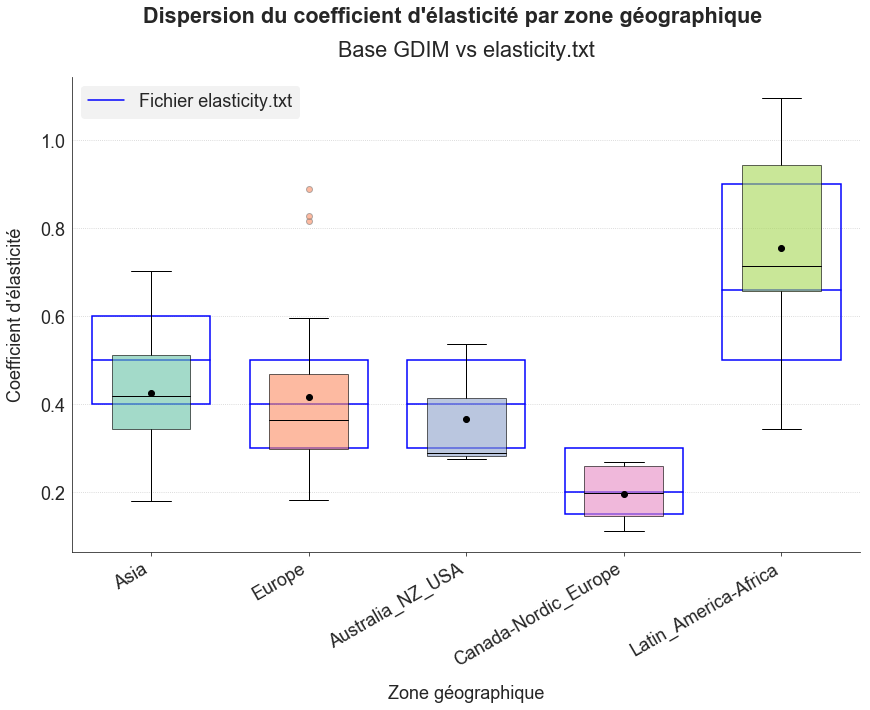

In [71]:
values = []
cat = elasticite.area.unique()
for i in cat:
    values.append(elasticite[elasticite.area==i].coef_elasticite)
graph30a = sfg.MyGraph("Dispersion du coefficient d'élasticité par zone géographique")
graph30a.add_boxplot(values=values, cat_labels=cat, width=0.5, alpha=0.6, means=True, subtitle="Base GDIM vs elasticity.txt")
for cpt in np.arange(len(cat)):
    graph30a.add_rectangle(coord_min=fichier_elasticity.loc[cat[cpt]].high_mobility, coord_max=fichier_elasticity.loc[cat[cpt]].low_mobility, vertical=False, rect_min=(cpt*0.2)+0.025, rect_max=(cpt*0.2)+0.175, color='blue')
    graph30a.add_line(coord=fichier_elasticity.loc[cat[cpt]].average_mobility, vertical=False, line_min=(cpt*0.2)+0.025, line_max=(cpt*0.2)+0.175, color='blue')
graph30a.add_plot(x_values=[0], y_values=[1], label="Fichier elasticity.txt", color='blue', legend=True)
graph30a.set_axe('x', label="Zone géographique", tick_dash=True, rotation=30, ha='right')
graph30a.set_axe('y', label="Coefficient d'élasticité")
fig, ax = graph30a.fig, graph30a.ax
plt.savefig("M3_dispersion_coef_elasticite.png")
plt.show()

Les données sont gloablement cohérentes entre la base GDIM et le fichier 'elasticity.txt'.

**Recherche d'un lien entre les indicateurs IGP, COR et IGEincome**

J'évalue, sur la base des 75 pays pour lesquels je dispose de ces informations, s'il existe un lien :  
- entre le coefficient de persistance du niveau d'études et le coefficient d'élasticité des revenus ;  
- ou entre le coefficient de corrélation du nombre d'années d'études des parents et des enfants et le coefficient d'élasticité des revenus.  
  
A noter qu'une valeur élevée de ces indicateurs indique une faible mobilité intergénérationnelle. Les trois coefficients mesurent la persistence intergénérationnelle.  
Si un lien existe, cela me permettra d'évaluer le coefficient d'élasticité avec la valeur de base ou avec les valeurs basses ou hautes de la région en fonction des indices IGP ou COR disponibles.

In [72]:
temp = igm[(~igm.IGEincome.isna()) & (~igm.IGP.isna())][["iso3","cohort","IGP","COR","IGEincome"]].groupby(["iso3","cohort"]).mean().reset_index()
print(len(temp))
temp.head()

72


,iso3,cohort,IGP,COR,IGEincome
0,ALB,1970,0.456693,0.402559,0.815874
1,AUS,1960,0.202700,0.266420,0.275000
2,AUT,1960,0.437402,0.487067,0.245267
3,BEL,1960,0.322624,0.454337,0.183176
4,BEN,1970,0.703738,0.520217,0.855116


In [73]:
reg1 = sfmr.LinearRegressionAnalysis(data=temp, y_name="IGEincome", array_X_names=["IGP","COR"], with_standardization=False)

C:\Anaconda3\envs\Jupyter\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


L'analyse a été calculée


In [74]:
reg1.df_linear_correl

,IGP,COR
IGEincome,,
Personn Correlation,0.496023,0.321123
p-value - H0:r=0,9.39038e-06,0.00595261
Test result (alpha = 5%),Corrélation significative,Corrélation significative


In [75]:
reg1.regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              IGEincome   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     11.26
Date:                Fri, 18 Oct 2019   Prob (F-statistic):           5.87e-05
Time:                        14:53:25   Log-Likelihood:                 7.8181
No. Observations:                  72   AIC:                            -9.636
Df Residuals:                      69   BIC:                            -2.806
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2119      0.115      1.839      0.070      -0.018       0.442
IGP            0.7092      0.196      3.617      0.001       0.318       1.100
COR           -0.0005      0.350     -0.001      0.999      -0.700       0.699
==============================================================================
Omnibus:                        3.094   Durbin-Watson:                   1.652
Prob(Omnibus):                  0.213   Jarque-Bera (JB):                2.426
Skew:                           0.311   Prob(JB):                        0.297
Kurtosis:                       2.350   Cond. No.                         17.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Le coefficient de corrélation entre COR et IGEincome, bien que significatif, est plus faible qu'entre IGP et IGEincome. De plus, dans la régression linéaire multiple, le coefficient de COR n'est pas significatif au seuil de 5% (p-value = 0.999 > 0.05) alors que celui d'IGP est significatif (p-value = 0.001).

In [76]:
reg1.remove_from_variables_retenues("COR")
reg1.regression.summary()

L'analyse a été calculée


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              IGEincome   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     22.84
Date:                Fri, 18 Oct 2019   Prob (F-statistic):           9.39e-06
Time:                        14:53:25   Log-Likelihood:                 7.8181
No. Observations:                  72   AIC:                            -11.64
Df Residuals:                      70   BIC:                            -7.083
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2117      0.070      3.041      0.003       0.073       0.351
IGP            0.7091      0.148      4.779      0.000       0.413       1.005
==============================================================================
Omnibus:                        3.095   Durbin-Watson:                   1.652
Prob(Omnibus):                  0.213   Jarque-Bera (JB):                2.426
Skew:                           0.311   Prob(JB):                        0.297
Kurtosis:                       2.350   Cond. No.                         6.83
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

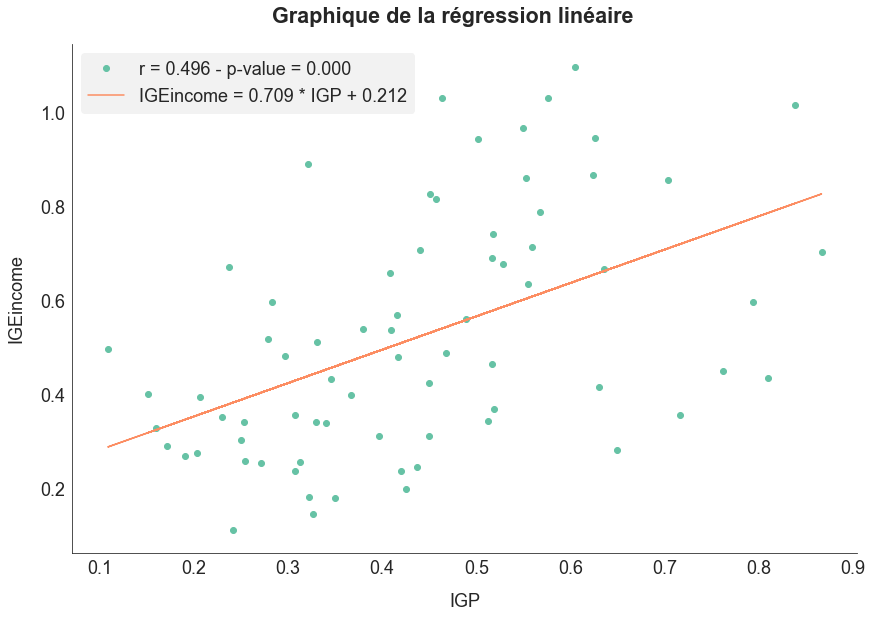

In [77]:
fig, ax = reg1.graph_linear_regression()
plt.show()

Un lien semble exister entre IGP et IGEincome, même si la dispersion autour de la droite de régression linéaire est assez importante (R-squared faible).

**Vérification d'un lien entre l'IGP et l'IGEincome par zone géographique**

Je vérifie visuellement l'existence de lien entre l'IGP et l'IGEincome par zone géographique.

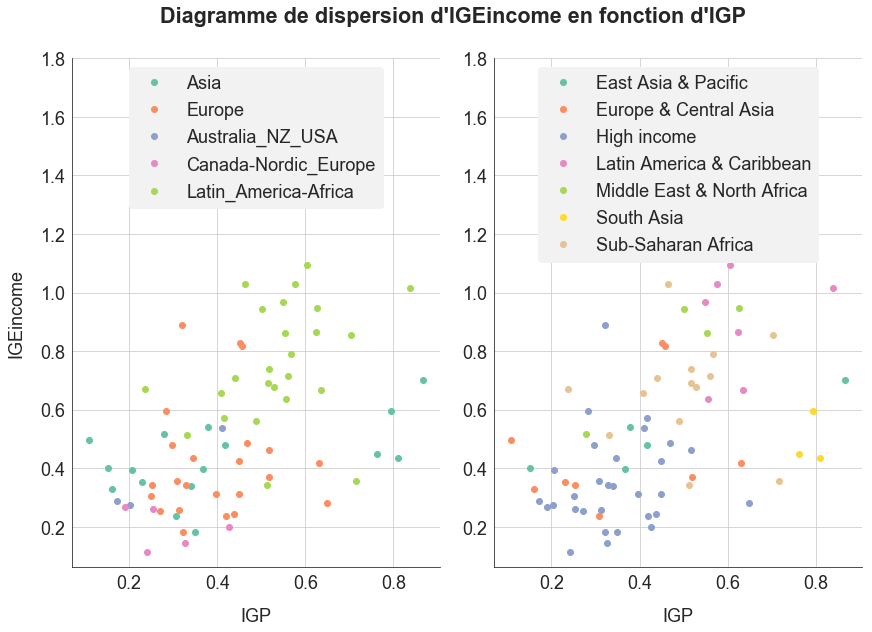

In [78]:
graph31 = sfg.MyGraph(title="Diagramme de dispersion d'IGEincome en fonction d'IGP", nblin=1, nbcol=2)
for area in countries_with_ige.area.unique():
    graph31.add_plot(x_values=countries_with_ige[countries_with_ige.area==area].IGP, y_values=countries_with_ige[countries_with_ige.area==area].IGEincome, label=area, marker="o", linestyle='', with_grid='both', multi_index=1)
for region in countries_with_ige.region.unique():
    graph31.add_plot(x_values=countries_with_ige[countries_with_ige.region==region].IGP, y_values=countries_with_ige[countries_with_ige.region==region].IGEincome, label=region, marker="o", linestyle='', with_grid='both', multi_index=2)
graph31.set_axe('x', label="IGP", multi_index=1)
graph31.set_axe('y', label="IGEincome", tick_max=1.8, multi_index=1)
graph31.set_axe('x', label="IGP", multi_index=2)
graph31.set_axe('y', tick_max=1.8, multi_index=2)
graph31.set_legend(loc="upper center", multi_index=1)
graph31.set_legend(loc="upper center", multi_index=2)
fig, ax = graph31.fig, graph31.ax
plt.savefig("M3_scatter_ige_igp.png")
plt.show()

Sur le graphique de gauche, il semble y avoir un lien entre l'IGP et l'IGEincome sur la région Amérique Latine / Afrique et en Asie, alors qu'en Europe l'IGEincome ne semble pas dépendre de l'IGP.  
Sur le graphique de droite, aucun lien évident ne ressort.
J'analyse la corrélation région par région.

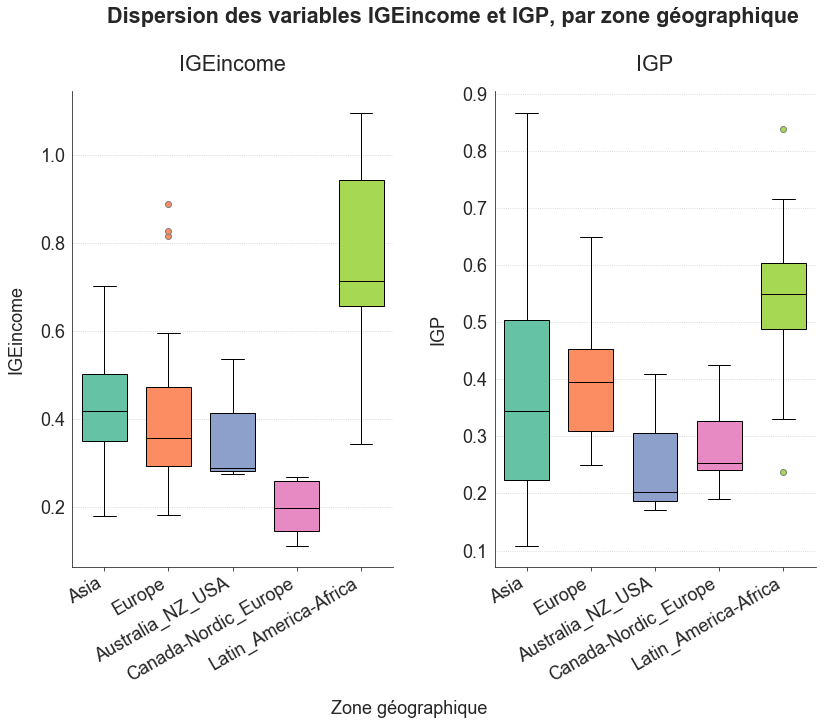

In [79]:
cat = countries_with_ige.area.unique()
graph32 = sfg.MyGraph("Dispersion des variables IGEincome et IGP, par zone géographique", nblin=1, nbcol=2)
values = []
for i in cat:
    values.append(countries_with_ige[(countries_with_ige.IGP.notna()) & (countries_with_ige.area==i)].IGEincome)
graph32.add_boxplot(values=values, cat_labels=cat, subtitle="IGEincome", multi_index=1)
values = []
for i in cat:
    values.append(countries_with_ige[(countries_with_ige.IGP.notna()) & (countries_with_ige.area==i)].IGP)
graph32.add_boxplot(values=values, cat_labels=cat, color_base_index=0, subtitle="IGP", multi_index=2)
graph32.set_axe('x', label="Zone géographique", label_position=(1.05,0.5), tick_dash=True, rotation=30, ha='right', multi_index=1)
graph32.set_axe('x', tick_dash=True, rotation=30, ha='right', multi_index=2)
graph32.set_axe('y', label="IGEincome", multi_index=1)
graph32.set_axe('y', label="IGP", multi_index=2)
fig, ax = graph32.fig, graph32.ax
plt.savefig("M3_boxplot_ige_igp.png")
plt.show()

Je remarque des valeurs atypiques : 2 valeurs atypiques pour l'IGP dans la zone Amérique Latine / Afrique et 3 valeurs atypiques pour l'IGEincome dans la zone Europe. Il faudra que j'enlève ces pays pour l'analyse de la corrélation entre l'IGP et l'IGEincome dans ces zones.  
Les plus fortes dispersions sont présentes en Asie pour l'IGP et en Afrique pour l'IGEincome.

La région Amérique Latine/Afrique présente la plus grande dispersion pour la variable IGEincome.  
L'Europe présente trois valeurs atypiques pour cette variable.

In [80]:
def analyse_IGP_area(area):
    data = countries_with_ige[(countries_with_ige.IGP.notna()) & (countries_with_ige.area==area)].copy()
    if area == 'Latin_America-Africa':
        data = data[data.IGP.between(0.3,0.8)]
    if area == 'Europe':
        data = data[data.IGEincome < 0.7]
    reg = sfmr.LinearRegressionAnalysis(data=data, y_name="IGEincome", array_X_names=["IGP"], with_standardization=False)
    print("\nRégion : {}".format(area))
    print(reg.df_linear_correl)
    stat, p_value = st.shapiro(reg.residus)
    if p_value >= 0.05:
        print("\nHypothèse de normalité des résidus acceptée")
    else:
        print("\nHypothèse de normalité des résidus rejetée")
    #fig, ax = reg.graph_linear_regression()
    #plt.show()

In [81]:
analyse_IGP_area(countries_with_ige.area.unique()[0])

L'analyse a été calculée

Région : Asia
                                                IGP
IGEincome                                          
Personn Correlation                        0.520328
p-value - H0:r=0                          0.0388057
Test result (alpha = 5%)  Corrélation significative

Hypothèse de normalité des résidus acceptée


In [82]:
analyse_IGP_area(countries_with_ige.area.unique()[1])

L'analyse a été calculée

Région : Europe
                                             IGP
IGEincome                                       
Personn Correlation                    0.0608791
p-value - H0:r=0                         0.79875
Test result (alpha = 5%)  Absence de corrélation

Hypothèse de normalité des résidus acceptée


In [83]:
analyse_IGP_area(countries_with_ige.area.unique()[2])

L'analyse a été calculée

Région : Australia_NZ_USA
                                             IGP
IGEincome                                       
Personn Correlation                      0.98526
p-value - H0:r=0                        0.109442
Test result (alpha = 5%)  Absence de corrélation

Hypothèse de normalité des résidus acceptée


C:\Anaconda3\envs\Jupyter\lib\site-packages\statsmodels\regression\linear_model.py:1558: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid
C:\Anaconda3\envs\Jupyter\lib\site-packages\statsmodels\regression\linear_model.py:1510: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
C:\Anaconda3\envs\Jupyter\lib\site-packages\numpy\linalg\linalg.py:2093: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [84]:
analyse_IGP_area(countries_with_ige.area.unique()[3])

L'analyse a été calculée

Région : Canada-Nordic_Europe
                                             IGP
IGEincome                                       
Personn Correlation                    -0.278608
p-value - H0:r=0                         0.64991
Test result (alpha = 5%)  Absence de corrélation

Hypothèse de normalité des résidus acceptée


In [85]:
analyse_IGP_area(countries_with_ige.area.unique()[4])

L'analyse a été calculée

Région : Latin_America-Africa
                                             IGP
IGEincome                                       
Personn Correlation                     0.203858
p-value - H0:r=0                        0.350822
Test result (alpha = 5%)  Absence de corrélation

Hypothèse de normalité des résidus acceptée


L'analyse détaillée par région montre que la corrélation entre l'IGP et l'IGEincome ne peut être utilisée que pour la région Asia.  
La corrélation pour la région Australie/Nouvelle-Zélande/USA n'est pas significative à cause du peu de pays dans la zone.  
Etonnamment, la corrélation n'est pas significative pour la région Amérique Latine/Afrique. Pour cette région, je vérifie le détail des valeurs et je regarde si la valeur de l'IGEincome change selon le continent.

In [86]:
subzone = countries_with_ige[countries_with_ige.area=='Latin_America-Africa'].copy()
subzone

,region,iso3,countryname,IGP,IGEincome,area
19,High income,CHL,Chile,0.416113,0.570000,Latin_America-Africa
46,Latin America & Caribbean,BOL,Bolivia,0.623477,0.866268,Latin_America-Africa
47,Latin America & Caribbean,BRA,Brazil,0.554925,0.635000,Latin_America-Africa
48,Latin America & Caribbean,COL,Colombia,0.604599,1.095440,Latin_America-Africa
49,Latin America & Caribbean,ECU,Ecuador,0.576339,1.029957,Latin_America-Africa
50,Latin America & Caribbean,GTM,Guatemala,0.838418,1.015206,Latin_America-Africa
51,Latin America & Caribbean,PAN,Panama,0.549463,0.966865,Latin_America-Africa
52,Latin America & Caribbean,PER,Peru,0.635211,0.667000,Latin_America-Africa
53,Middle East & North Africa,EGY,"Egypt, Arab Rep.",0.501950,0.943205,Latin_America-Africa
55,Middle East & North Africa,MAR,Morocco,0.626294,0.945744,Latin_America-Africa


In [87]:
subzone.loc[19:52,"subzone"] = "Latin_America"
subzone.loc[53:74,"subzone"] = "Africa"
subzone[subzone.subzone=="Latin_America"][["IGP","IGEincome"]].describe()

,IGP,IGEincome
count,8.000000,8.000000
mean,0.599818,0.855717
std,0.118089,0.204133
min,0.416113,0.570000
25%,0.553559,0.659000
50%,0.590469,0.916566
75%,0.626411,1.018894
max,0.838418,1.095440


In [88]:
subzone[subzone.subzone=="Africa"][["IGP","IGEincome"]].describe()

,IGP,IGEincome
count,17.000000,17.000000
mean,0.510102,0.708977
std,0.118842,0.191877
min,0.237010,0.342855
25%,0.463935,0.657949
50%,0.516249,0.707703
75%,0.559528,0.855116
max,0.715985,1.029195


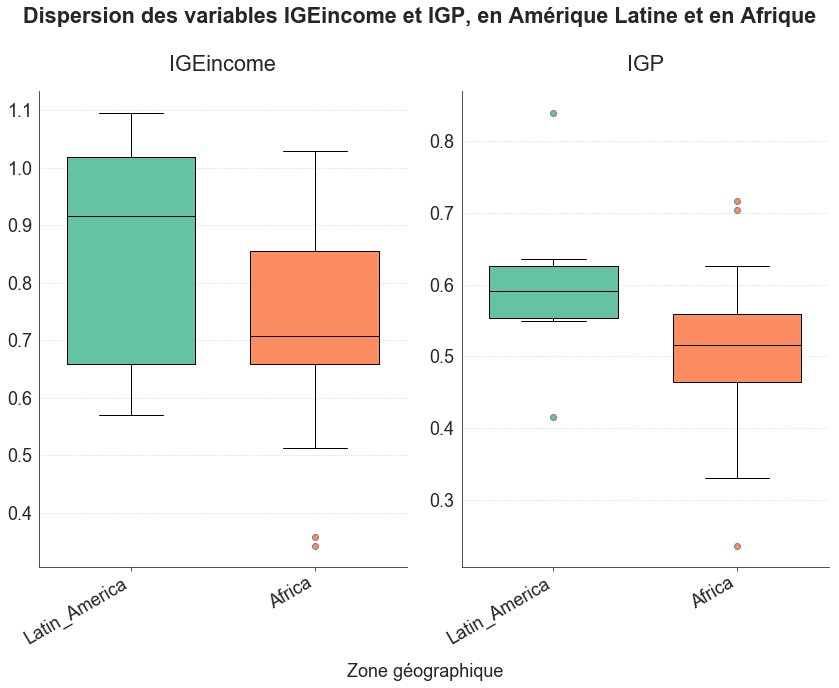

In [89]:
cat = subzone.subzone.unique()
graph33 = sfg.MyGraph("Dispersion des variables IGEincome et IGP, en Amérique Latine et en Afrique", nblin=1, nbcol=2)
values = []
for i in cat:
    values.append(subzone[subzone.subzone==i].IGEincome)
graph33.add_boxplot(values=values, cat_labels=cat, subtitle="IGEincome", multi_index=1)
values = []
for i in cat:
    values.append(subzone[subzone.subzone==i].IGP)
graph33.add_boxplot(values=values, cat_labels=cat, color_base_index=0, subtitle="IGP", multi_index=2)
graph33.set_axe('x', label="Zone géographique", label_position=(1.05,0.5), tick_dash=True, rotation=30, ha='right', multi_index=1)
graph33.set_axe('x', tick_dash=True, rotation=30, ha='right', multi_index=2)
fig, ax = graph33.fig, graph33.ax
plt.show()

Cette analyse complémentaire montre qu'il est difficile de discriminer la valeur d'IGEincome en fonction du continent pour les pays de la zone Amérique Latine / Afrique.  
  
**En conclusion, on ne peut sélectionner la valeur de l'IGEincome en fonction de la valeur de l'IGP que dans la zone Asia. Il faut prendre la valeur moyenne dans les autres zones sans information supplémentaire.** Cette limitation est problématique.

Je cherche d'autres variables qui peuvent influencer l'indicateur IGEincome.

**Vérification de l'existence d'un lien entre le revenu moyen ou l'indice de Gini et l'IGEincome**

In [90]:
income = pd.read_csv("save_income_201909.csv", index_col="country_code")
income.head()

,year,revenu_moyen,pib_par_habitant,gini,gini_from_centiles,population,nb_annees_gini,country
country_code,,,,,,,,
ALB,2008,2994.829902,7297.0,30.0,32.141019,2991651.0,3.0,Albania
ARG,2008,5847.884654,13220.0,44.5,46.524916,40382389.0,12.0,Argentina
ARM,2008,1628.382785,5611.0,29.2,28.030458,2908220.0,13.0,Armenia
AUT,2008,16637.600204,36193.0,30.4,29.532585,8338453.0,13.0,Austria
AZE,2008,2357.429023,8101.0,NaN,32.903087,8821908.0,3.0,Azerbaijan


In [91]:
countries_with_ige = countries_with_ige.merge(income[["revenu_moyen","gini_from_centiles"]], how='left', left_on='iso3', right_index=True)
countries_with_ige.head()

,region,iso3,countryname,IGP,IGEincome,area,revenu_moyen,gini_from_centiles
0,East Asia & Pacific,CHN,China,0.367084,0.399000,Asia,2522.758726,49.333225
1,East Asia & Pacific,MNG,Mongolia,0.150777,0.401002,Asia,2338.087424,37.430746
2,East Asia & Pacific,MYS,Malaysia,0.379392,0.540000,Asia,6006.342359,48.333538
3,East Asia & Pacific,TLS,Timor-Leste,0.866754,0.701994,Asia,727.610395,33.641588
4,East Asia & Pacific,VNM,Vietnam,0.417062,0.480000,Asia,1377.773966,39.354551


In [92]:
countries_with_ige.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75 entries, 0 to 74
Data columns (total 8 columns):
region                75 non-null object
iso3                  75 non-null object
countryname           75 non-null object
IGP                   72 non-null float64
IGEincome             75 non-null float64
area                  75 non-null object
revenu_moyen          66 non-null float64
gini_from_centiles    66 non-null float64
dtypes: float64(4), object(4)
memory usage: 5.3+ KB


Il y a 9 pays pour lesquels je ne dispose pas du revenu moyen ni de l'indice de Gini. Je regarde de quels pays il s'agit. Puis je trace les diagrammes de dispersion de l'IGEincome en fonction du revenu moyen et de l'indice de Gini.

In [93]:
countries_with_ige[countries_with_ige.revenu_moyen.isna()]

,region,iso3,countryname,IGP,IGEincome,area,revenu_moyen,gini_from_centiles
13,Europe & Central Asia,UZB,Uzbekistan,0.108527,0.496764,Asia,NaN,NaN
14,High income,AUS,Australia,0.202700,0.275000,Australia_NZ_USA,NaN,NaN
18,High income,CHE,Switzerland,0.270725,0.254594,Europe,NaN,NaN
38,High income,NZL,New Zealand,0.171433,0.290000,Australia_NZ_USA,NaN,NaN
40,High income,SGP,Singapore,NaN,0.260000,Asia,NaN,NaN
56,Middle East & North Africa,TUN,Tunisia,0.552685,0.860433,Latin_America-Africa,NaN,NaN
61,Sub-Saharan Africa,BEN,Benin,0.703738,0.855116,Latin_America-Africa,NaN,NaN
63,Sub-Saharan Africa,ETH,Ethiopia,0.715985,0.357000,Latin_America-Africa,NaN,NaN
71,Sub-Saharan Africa,RWA,Rwanda,0.567873,0.788691,Latin_America-Africa,NaN,NaN


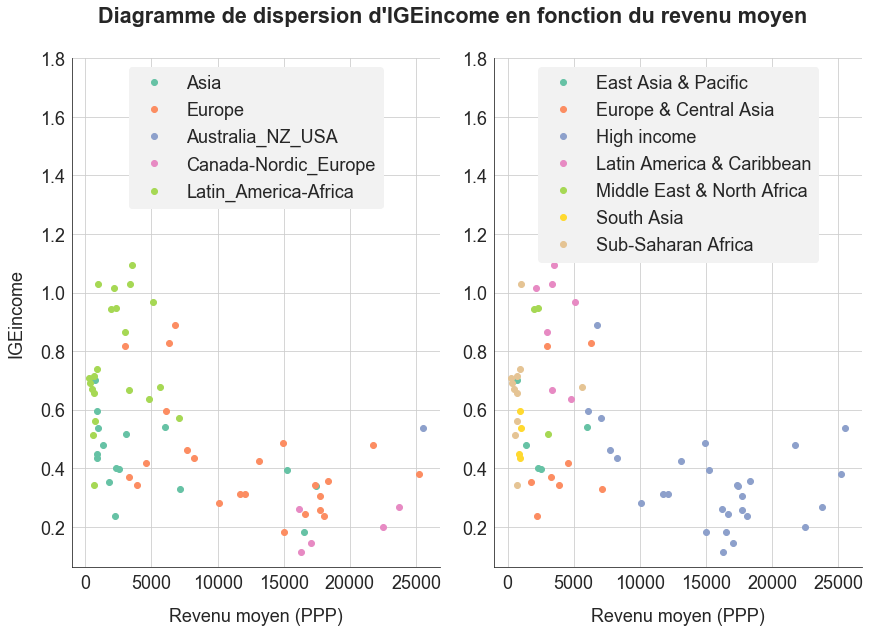

In [94]:
graph34 = sfg.MyGraph(title="Diagramme de dispersion d'IGEincome en fonction du revenu moyen", nblin=1, nbcol=2)
for area in countries_with_ige.area.unique():
    graph34.add_plot(x_values=countries_with_ige[countries_with_ige.area==area].revenu_moyen, y_values=countries_with_ige[countries_with_ige.area==area].IGEincome, label=area, marker="o", linestyle='', with_grid='both', multi_index=1)
for region in countries_with_ige.region.unique():
    graph34.add_plot(x_values=countries_with_ige[countries_with_ige.region==region].revenu_moyen, y_values=countries_with_ige[countries_with_ige.region==region].IGEincome, label=region, marker="o", linestyle='', with_grid='both', multi_index=2)
graph34.set_axe('x', label="Revenu moyen (PPP)", multi_index=1)
graph34.set_axe('y', label="IGEincome", tick_max=1.8, multi_index=1)
graph34.set_axe('x', label="Revenu moyen (PPP)", multi_index=2)
graph34.set_axe('y', tick_max=1.8, multi_index=2)
graph34.set_legend(loc="upper center", multi_index=1)
graph34.set_legend(loc="upper center", multi_index=2)
fig, ax = graph34.fig, graph34.ax
plt.savefig("M3_scatter_ige_revenumoyen.png")
plt.show()

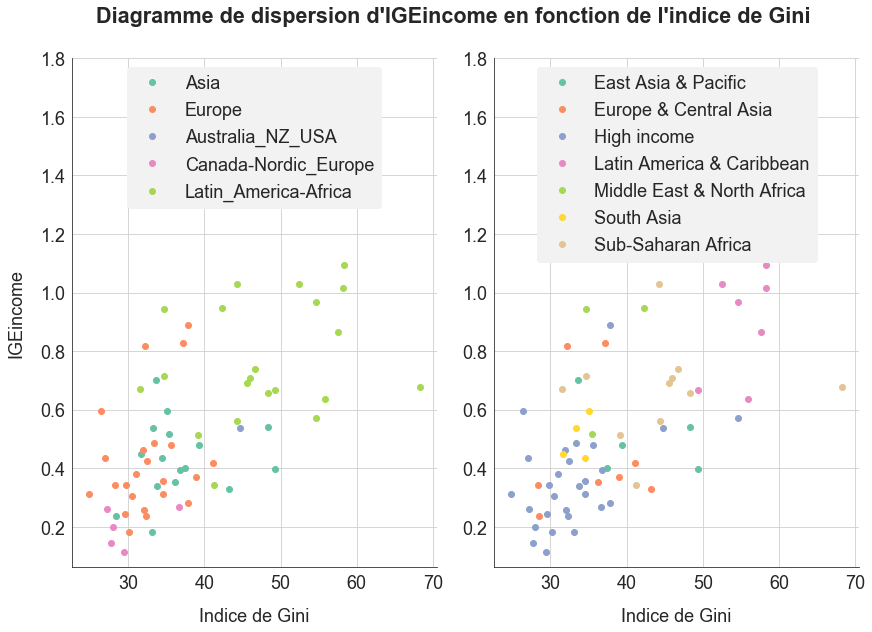

In [95]:
graph35 = sfg.MyGraph(title="Diagramme de dispersion d'IGEincome en fonction de l'indice de Gini", nblin=1, nbcol=2)
for area in countries_with_ige.area.unique():
    graph35.add_plot(x_values=countries_with_ige[countries_with_ige.area==area].gini_from_centiles, y_values=countries_with_ige[countries_with_ige.area==area].IGEincome, label=area, marker="o", linestyle='', with_grid='both', multi_index=1)
for region in countries_with_ige.region.unique():
    graph35.add_plot(x_values=countries_with_ige[countries_with_ige.region==region].gini_from_centiles, y_values=countries_with_ige[countries_with_ige.region==region].IGEincome, label=region, marker="o", linestyle='', with_grid='both', multi_index=2)
graph35.set_axe('x', label="Indice de Gini", multi_index=1)
graph35.set_axe('y', label="IGEincome", tick_max=1.8, multi_index=1)
graph35.set_axe('x', label="Indice de Gini", multi_index=2)
graph35.set_axe('y', tick_max=1.8, multi_index=2)
graph35.set_legend(loc="upper center", multi_index=1)
graph35.set_legend(loc="upper center", multi_index=2)
fig, ax = graph35.fig, graph35.ax
plt.savefig("M3_scatter_ige_gini.png")
plt.show()

Le premier graphique montre que les pays avec un revenu moyen plus élevé tendent à avoir un coefficient d'élasticité des revenus plus faible, donc une meilleure mobilité inter-générationnelle des revenus. Par contre, il semble difficile de tirer des informations à l'intérieur de la plupart des zones géographiques.  
Le deuxième graphique est très intéressant car il montre un lien assez évident entre l'indice de Gini et l'IGEincome. Plus les revenus sont concentrés au sein d'un pays (indice de Gini élevé), moins la mobilité inter-générationnelle ne semble efficace (IGEincome élevé). Je vérifie plus en détail cette relation.

In [96]:
data = countries_with_ige[countries_with_ige.gini_from_centiles.notna()].copy()
reg = sfmr.LinearRegressionAnalysis(data=data, y_name="IGEincome", array_X_names=["gini_from_centiles"], with_standardization=False)
print(reg.df_linear_correl)
stat, p_value = st.shapiro(reg.residus)
if p_value >= 0.05:
    print("\nHypothèse de normalité des résidus acceptée")
else:
    print("\nHypothèse de normalité des résidus rejetée")

L'analyse a été calculée
                                 gini_from_centiles
IGEincome                                          
Personn Correlation                        0.616458
p-value - H0:r=0                        3.57406e-08
Test result (alpha = 5%)  Corrélation significative

Hypothèse de normalité des résidus rejetée


La corrélation linéaire entre l'indice de Gini et l'IGEincome est significative et assez bien alignée (coefficient de Pearson égale à 0.62). Toutefois la distribution des résidus n'est pas normale et cet indicateur n'est pas disponible pour tous les pays.  
J'analyse si la région indiquée pour chaque pays dans la base GDIM influe sur la valeur de l'IGEincome.

**Vérification de l'existence d'un lien entre les zones géographiques et l'IGEincome**

In [97]:
list_area = pd.DataFrame({"area":np.sort(countries_with_ige.area.unique()), \
                          "myx":np.arange(len(countries_with_ige.area.unique()))})
intergraph = countries_with_ige[["iso3","area","region","IGEincome"]].copy()
intergraph = intergraph.merge(list_area, how='left', on="area")
intergraph.head()

,iso3,area,region,IGEincome,myx
0,CHN,Asia,East Asia & Pacific,0.399000,0
1,MNG,Asia,East Asia & Pacific,0.401002,0
2,MYS,Asia,East Asia & Pacific,0.540000,0
3,TLS,Asia,East Asia & Pacific,0.701994,0
4,VNM,Asia,East Asia & Pacific,0.480000,0


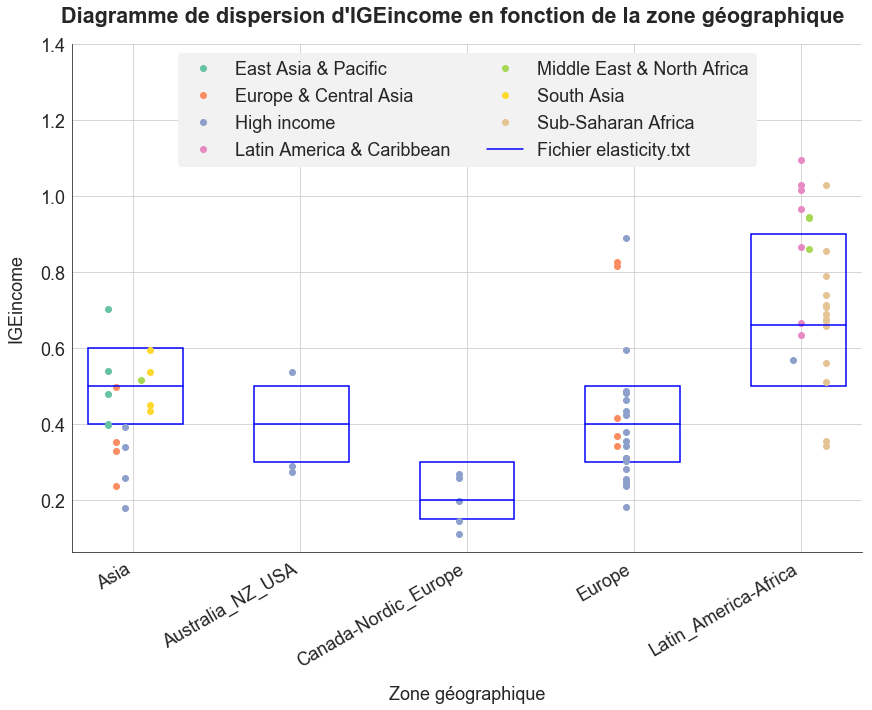

In [98]:
graph36 = sfg.MyGraph(title="Diagramme de dispersion d'IGEincome en fonction de la zone géographique")
for cpt, region in enumerate(intergraph.region.unique()):
    graph36.add_plot(x_values = intergraph[intergraph.region==region].myx + (cpt - 3) * 0.05, \
                     y_values=intergraph[intergraph.region==region].IGEincome, \
                     label=region, marker="o", linestyle='', with_grid='both')
for cpt in np.arange(len(list_area)):
    graph36.add_rectangle(coord_min=fichier_elasticity.loc[list_area.loc[cpt,"area"]].high_mobility, \
                          coord_max=fichier_elasticity.loc[list_area.loc[cpt,"area"]].low_mobility, \
                          rect_min=(list_area.loc[cpt,"myx"] + 0.15 + ((cpt-1) * 0.05)) * 0.2, \
                          rect_max=(list_area.loc[cpt,"myx"] + 0.85 - ((3-cpt) * 0.05)) * 0.2, \
                          color='blue', vertical=False)
    graph36.add_line(coord=fichier_elasticity.loc[list_area.loc[cpt,"area"]].average_mobility, \
                     line_min = (list_area.loc[cpt,"myx"] + 0.15 + ((cpt-1) * 0.05)) * 0.2, \
                     line_max = (list_area.loc[cpt,"myx"] + 0.85 - ((3-cpt) * 0.05)) * 0.2, \
                     color='blue',vertical=False)
graph36.add_plot(x_values=[0], y_values=[1], label="Fichier elasticity.txt", color='blue')
graph36.set_axe('x', label="Zone géographique", tick_min=0, tick_max=4.5, tick_step=1, \
                tick_labels=list_area.area, rotation=30, ha='right')
graph36.set_axe('y', label="IGEincome", tick_max=1.4)
graph36.set_legend(loc="upper center", ncol=2)
fig, ax = graph36.fig, graph36.ax
plt.savefig("M3_ige_zonegeo.png")
plt.show()

Ce graphique est très utile car il offre une classification facile et parlante des pays en fonction de la zone géographique contenue dans le fichier GDIM :  
- Asie : les pays des régions 'High Income' et 'Europe & Central Asia' se voient attribués un coefficient d'élasticité de forte mobilité des revenus. Les pays des autres régions se voient attribués la valeur moyenne du fichier elasticity.  
- Australie / Nouvelle-Zélande / USA : j'ai déjà l'information pour tous les pays.  
- Canada / Europe du Nord : je prends la valeur moyenne du fichier elasticity.  
- Europe : le coefficient d'élasticité prend des valeurs variées pour tous les pays quelque soit leur origine mais avec une tendance à des valeurs moyennes plus élevées pour les pays de la zone 'Europe & Asie Centrale" par rapport aux pays 'High Income'. Par conséquent, IGEincome est estimé par la moyenne entre la valeur optimiste et la valeur moyenne du fichier elasticity pour les pays 'High Income' et par la moyenne entre la valeur pessimiste et la valeur moyenne pour les autres pays ('Europe & Asie Centrale').   
- Amérique Latine / Afrique : les pays de la catégorie 'High Income' reçoivent la valeur optimiste. J'attribue la valeur moyenne aux pays d'Afrique sub-saharienne. Les autres pays se voient attribués la valeur pessimiste du fichier elasticity.  
  
Dans tous les cas, je prends la valeur moyenne si je n'ai pas d'autre information.

**Estimation des valeurs manquantes d'IGEincome**

In [99]:
inter_elast = countries_without_ige[["iso3","countryname","area","region"]].copy()
inter_elast.columns = ["country_code","country_name","area","region"]
inter_elast["decennie_etudiee"] = np.nan

In [100]:
for i, row in inter_elast.iterrows():
    if row["area"] == "Asia":
        if (row["region"] == "High income") | (row["region"] == "Europe & Central Asia"):
            inter_elast.loc[i,"coef_elasticite"] = fichier_elasticity.loc[row["area"]].high_mobility
        elif (row["region"] == "East Asia & Pacific") | (row["region"] == "Middle East & North Africa") | (row["region"] == "South Asia"):
            inter_elast.loc[i,"coef_elasticite"] = fichier_elasticity.loc[row["area"]].average_mobility
        else:
            inter_elast.loc[i,"coef_elasticite"] = fichier_elasticity.loc[row["area"]].average_mobility  # moyenne dans les autres cas
    elif row["area"] == "Canada-Nordic_Europe":
        inter_elast.loc[i,"coef_elasticite"] = fichier_elasticity.loc[row["area"]].average_mobility
    elif row["area"] == "Europe":
        if row["region"] == "High income":
            inter_elast.loc[i,"coef_elasticite"] = (fichier_elasticity.loc[row["area"]].average_mobility + \
                                                fichier_elasticity.loc[row["area"]].high_mobility) / 2
        elif row["region"] == "Europe & Central Asia":
            inter_elast.loc[i,"coef_elasticite"] = (fichier_elasticity.loc[row["area"]].average_mobility + \
                                                fichier_elasticity.loc[row["area"]].low_mobility) / 2
        else:
            inter_elast.loc[i,"coef_elasticite"] = fichier_elasticity.loc[row["area"]].average_mobility  # moyenne dans les autres cas
    elif row["area"] == "Latin_America-Africa":
        if row["region"] == "High income":
            inter_elast.loc[i,"coef_elasticite"] = fichier_elasticity.loc[row["area"]].high_mobility
        elif row["region"] == "Sub-Saharan Africa":
            inter_elast.loc[i,"coef_elasticite"] = fichier_elasticity.loc[row["area"]].average_mobility
        elif (row["region"] == "Latin America & Caribbean") | (row["region"] == "Middle East & North Africa"):
            inter_elast.loc[i,"coef_elasticite"] = fichier_elasticity.loc[row["area"]].low_mobility
        else:
            inter_elast.loc[i,"coef_elasticite"] = fichier_elasticity.loc[row["area"]].average_mobility
    else:
        inter_elast.loc[i,"coef_elasticite"] = np.nan

In [101]:
inter_elast.set_index("country_code", inplace=True)
inter_elast = inter_elast[["country_name","decennie_etudiee","coef_elasticite","region","area"]]
print(inter_elast.head())
print(inter_elast.tail())
print("\nNombre de pays sans estimation = {} (vérification - doit être égal à 0)".format(len(inter_elast[inter_elast.coef_elasticite.isna()])))

             country_name  decennie_etudiee  coef_elasticite  \
country_code                                                   
FJI                  Fiji               NaN              0.5   
IDN             Indonesia               NaN              0.5   
KHM              Cambodia               NaN              0.5   
KIR              Kiribati               NaN              0.5   
LAO               Lao PDR               NaN              0.5   

                           region  area  
country_code                             
FJI           East Asia & Pacific  Asia  
IDN           East Asia & Pacific  Asia  
KHM           East Asia & Pacific  Asia  
KIR           East Asia & Pacific  Asia  
LAO           East Asia & Pacific  Asia  
                       country_name  decennie_etudiee  coef_elasticite  \
country_code                                                             
STP           Sao Tome and Principe               NaN             0.66   
SWZ                       Swaziland

In [102]:
elasticite = pd.concat([elasticite, inter_elast])
print("Verification - tous les pays du fichier ont un coefficient d'élasticité renseigné : {}".\
      format(len(elasticite[elasticite.coef_elasticite.isna()])==0))
print("Nombre de pays avec un coefficient d'élasticité : {}".format(len(elasticite)))
elasticite.head()

Verification - tous les pays du fichier ont un coefficient d'élasticité renseigné : True
Nombre de pays avec un coefficient d'élasticité : 150


,country_name,decennie_etudiee,coef_elasticite,region,area
country_code,,,,,
CHN,China,1960.0,0.399000,East Asia & Pacific,Asia
MNG,Mongolia,1970.0,0.401002,East Asia & Pacific,Asia
MYS,Malaysia,1960.0,0.540000,East Asia & Pacific,Asia
TLS,Timor-Leste,1970.0,0.701994,East Asia & Pacific,Asia
VNM,Vietnam,1960.0,0.480000,East Asia & Pacific,Asia


In [103]:
# sauvegarde des coefficients d'élasticité
#elasticite.to_csv("save_elasticite.csv")

<a id='3_2'></a>

### 3.2. Génération des variables ln_y_parents, residus et y_child

In [104]:
def generate_income(iso3, nb_individus):
    pj = elasticite.loc[iso3].coef_elasticite
    ln_y_parent = np.random.normal(size=nb_individus)  # moyenne et ecart-type sans importance -> on prend une loi normale centrée réduite
    y_parent = np.exp(ln_y_parent)
    residual = np.random.normal(size=nb_individus)
    y_child = np.exp((pj * ln_y_parent) + residual)
    return y_parent, y_child

In [105]:
nb_quantiles = 100
nb_individus = 1000 * nb_quantiles
df_parents_income = pd.DataFrame(index=np.arange(nb_individus), columns=elasticite.index.values)
df_children_income = pd.DataFrame(index=np.arange(nb_individus), columns=elasticite.index.values)
for iso3 in elasticite.index.values:
    parents_income, children_income = generate_income(iso3, nb_individus)
    df_parents_income[iso3] = parents_income
    df_children_income[iso3] = children_income

<a id='3_3'></a>

### 3.3. Génération des classes de revenus et des probabilités conditionnelles

In [106]:
def calculate_quantiles(data_series, nb_quantiles):
    quantiles_values = np.percentile(data_series, np.linspace(0, 100, nb_quantiles + 1))
    quantiles_series = []
    for data_value in data_series:
        cpt = 1
        while data_value > quantiles_values[cpt]:
            cpt += 1
        quantiles_series.append(cpt)
    return quantiles_series

In [107]:
df_parents_quantiles = pd.DataFrame(index=np.arange(nb_individus), columns=elasticite.index.values)
df_children_quantiles = pd.DataFrame(index=np.arange(nb_individus), columns=elasticite.index.values)
for iso3 in elasticite.index.values:
    df_parents_quantiles[iso3] = calculate_quantiles(df_parents_income[iso3], nb_quantiles)
    df_children_quantiles[iso3] = calculate_quantiles(df_children_income[iso3], nb_quantiles)

In [108]:
def calculate_conditional_proba(parent_series, child_series):
    df_calcul = pd.DataFrame({"quantile_parent":parent_series, "quantile_child":child_series})
    df_calcul["nombre"] = 1
    result = df_calcul.groupby(["quantile_parent","quantile_child"]).count().reset_index()
    total_child = df_calcul[["quantile_child","nombre"]].groupby("quantile_child").count().reset_index()
    result = result.merge(total_child, how='left', on="quantile_child").set_index(["quantile_parent","quantile_child"])
    result.columns = ["distrib","nb_child"]
    result["conditional_proba"] = result.distrib / result.nb_child
    return result.conditional_proba

In [109]:
inter_index = np.meshgrid(np.arange(1,nb_quantiles+1),np.arange(1,nb_quantiles+1))
index_child = inter_index[0].flatten()
index_parent = inter_index[1].flatten()
df_conditional_distribution = pd.DataFrame(index=[index_parent, index_child], columns=elasticite.index.values)
df_conditional_distribution.index.names = ["quantile_parent","quantile_child"]
for iso3 in df_conditional_distribution.columns:
    df_conditional_distribution[iso3] = calculate_conditional_proba(df_parents_quantiles[iso3], df_children_quantiles[iso3])

<a id='3_4'></a>

### 3.4. Graphiques de vérification des probabilités conditionnelles

Pour vérifier graphiquement, je regroupe mes centiles en déciles. En effet, un graphique avec les centiles serait illisible.

In [110]:
def deciles_conditional_proba_from_centiles(conditional_distrib):
    conditional_distrib["decile_parent"] = ((conditional_distrib.quantile_parent - 1) // 10) + 1
    conditional_distrib["decile_child"] = ((conditional_distrib.quantile_child - 1) // 10) + 1
    conditional_distrib.drop(columns=["quantile_parent","quantile_child"], inplace=True)
    graph_data = conditional_distrib.groupby(["decile_parent","decile_child"]).sum() / 10  
    # je divise par 10 car la somme des proba conditionnelles est égale à un pour chaque centile de parents
    # donc égale à 10 pour chaque décile de parent. Il faut corriger.
    graph_data.columns = ["conditional_proba"]
    return graph_data.conditional_proba

In [111]:
def get_graph_data(country_code):
    inter_index = np.meshgrid(np.arange(1,11),np.arange(1,11))
    index_child = inter_index[0].flatten()
    index_parent = inter_index[1].flatten()
    check_graph_data = pd.DataFrame(index=[index_parent, index_child], columns=["conditional_proba","bottom_bar"])
    check_graph_data.index.names = ["decile_parent","decile_child"]
    check_graph_data.conditional_proba = deciles_conditional_proba_from_centiles(df_conditional_distribution[country_code].reset_index())
    check_graph_data.reset_index(inplace=True)
    for i, row in check_graph_data.iterrows():
        check_graph_data.loc[i,"bottom_bar"] = check_graph_data[(check_graph_data.decile_parent == row.decile_parent) & (check_graph_data.decile_child < row.decile_child)].conditional_proba.sum()
    return check_graph_data

Je fais 2 graphiques d'illustration :
- l'un avec les deux pays aux valeurs extrêmes d'élasticité
- l'autre avec le pays qui correspond à la valeur médiane de l'élasticité et avec la France

In [112]:
choix_pays = elasticite.sort_values(by="coef_elasticite")
pays_graph = np.append(choix_pays.index[[0,-1,int(len(choix_pays)/2)]].values,"FRA")
pays_graph

array(['FIN', 'COL', 'KHM', 'FRA'], dtype=object)

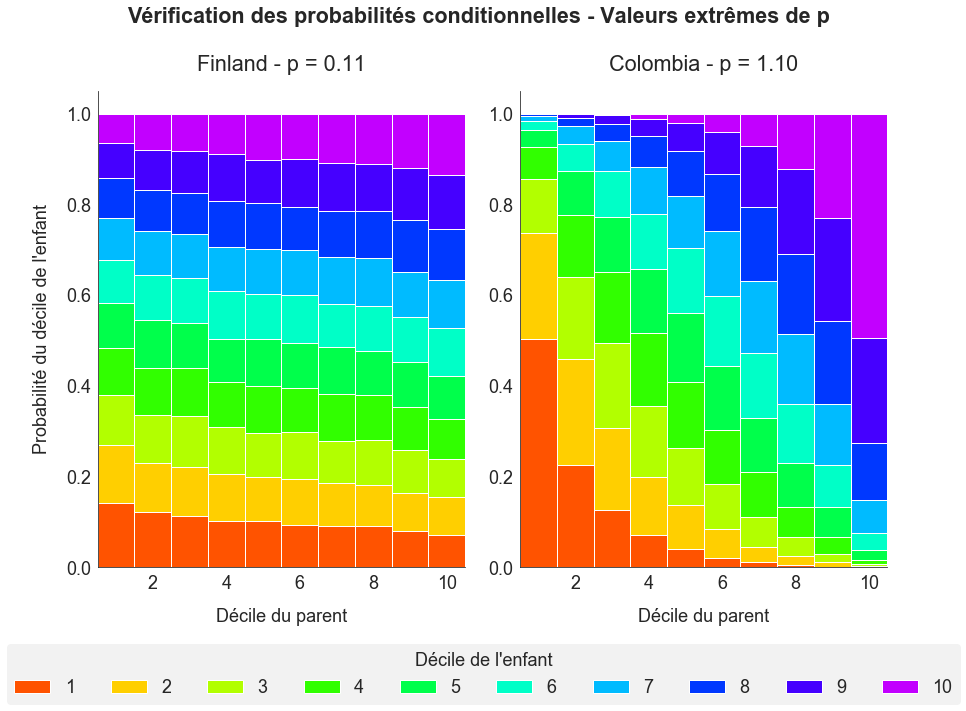

In [113]:
graph36 = sfg.MyGraph("Vérification des probabilités conditionnelles - Valeurs extrêmes de p", nblin=1, nbcol=2)
for idx, pays in enumerate(pays_graph[:2]):
    data_pays = get_graph_data(pays)
    for cpt, dc in enumerate(data_pays.decile_child.unique()):
        graph36.add_barv(x_values=data_pays[data_pays.decile_child==dc].decile_parent, \
                         y_height=data_pays[data_pays.decile_child==dc].conditional_proba, \
                        y_bottom=data_pays[data_pays.decile_child==dc].bottom_bar, \
                        label=dc, color=sfg.get_rainbow_colors(10)[cpt],bar_width=1, multi_index=idx+1)
    graph36._MyGraph__add_legend_subtitle(multi_index=idx+1, legend=False, subtitle="{} - p = {:.2f}".format(elasticite.loc[pays].country_name, elasticite.loc[pays].coef_elasticite))
graph36.set_axe('x', label="Décile du parent", tick_min=0.5, tick_max=10.5, multi_index=1)
graph36.set_axe('x', label="Décile du parent", tick_min=0.5, tick_max=10.5, multi_index=2)
graph36.set_axe('y', label="Probabilité du décile de l'enfant", multi_index=1)
graph36.set_legend(loc='center', bbox_to_anchor=(1.05,-0.225), ncol=10, title="Décile de l'enfant", multi_index=1)
fig, ax = graph36.fig, graph36.ax
plt.savefig("M3_proba_cond_extremes.png")
plt.show()

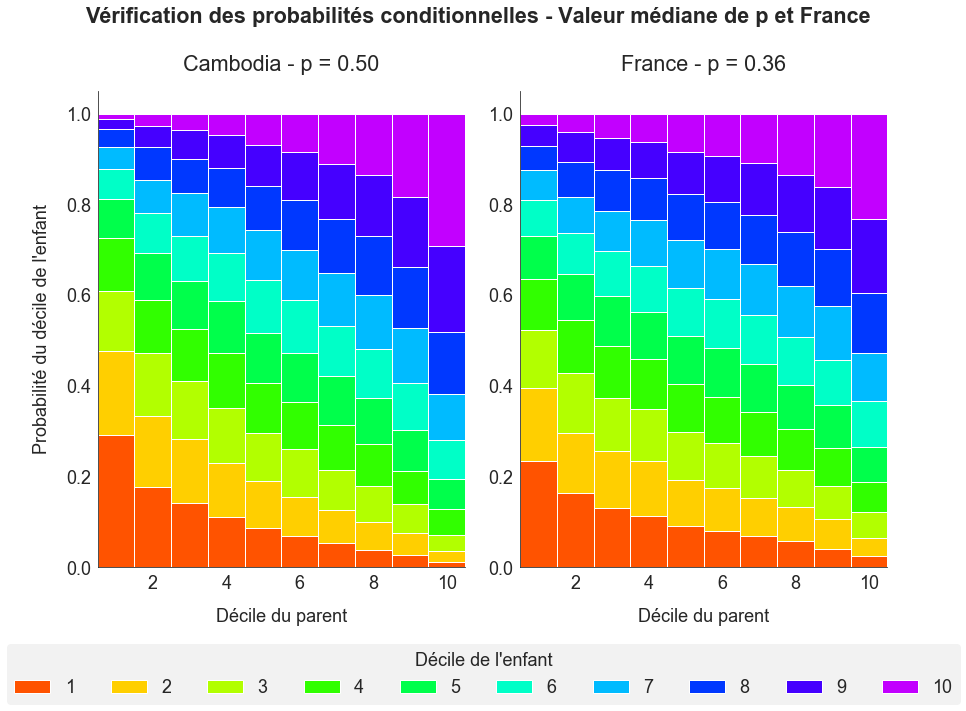

In [114]:
graph37 = sfg.MyGraph("Vérification des probabilités conditionnelles - Valeur médiane de p et France", nblin=1, nbcol=2)
for idx, pays in enumerate(pays_graph[2:]):
    data_pays = get_graph_data(pays)
    for cpt, dc in enumerate(data_pays.decile_child.unique()):
        graph37.add_barv(x_values=data_pays[data_pays.decile_child==dc].decile_parent, \
                         y_height=data_pays[data_pays.decile_child==dc].conditional_proba, \
                        y_bottom=data_pays[data_pays.decile_child==dc].bottom_bar, \
                        label=dc, color=sfg.get_rainbow_colors(10)[cpt],bar_width=1, multi_index=idx+1)
    graph37._MyGraph__add_legend_subtitle(multi_index=idx+1, legend=False, subtitle="{} - p = {:.2f}".format(elasticite.loc[pays].country_name, elasticite.loc[pays].coef_elasticite))
graph37.set_axe('x', label="Décile du parent", tick_min=0.5, tick_max=10.5, multi_index=1)
graph37.set_axe('x', label="Décile du parent", tick_min=0.5, tick_max=10.5, multi_index=2)
graph37.set_axe('y', label="Probabilité du décile de l'enfant", multi_index=1)
graph37.set_legend(loc='center', bbox_to_anchor=(1.05,-0.225), ncol=10, title="Décile de l'enfant", multi_index=1)
fig, ax = graph37.fig, graph37.ax
plt.savefig("M3_proba_cond_mediane.png")
plt.show()

Les graphiques sont satisfaisants. Je transforme les np.nan en 0, puis je sauvegarde le dataframe des distributions conditionnelles.

In [115]:
df_conditional_distribution.fillna(0, inplace=True)
#df_conditional_distribution.to_csv("save_conditional_distribution.csv")
df_conditional_distribution.head()

CHN    MNG    MYS    TLS    VNM    ALB  \
quantile_parent quantile_child                                             
1               1               0.078  0.081  0.128  0.168  0.107  0.230   
                2               0.059  0.052  0.064  0.101  0.068  0.101   
                3               0.048  0.039  0.060  0.074  0.053  0.086   
                4               0.035  0.032  0.042  0.055  0.049  0.069   
                5               0.037  0.036  0.046  0.048  0.044  0.067   

                                  BIH    BLR    KAZ    KGZ  ...    NER    SDN  \
quantile_parent quantile_child                              ...                 
1               1               0.224  0.054  0.041  0.063  ...  0.153  0.156   
                2               0.114  0.044  0.034  0.033  ...  0.091  0.068   
                3               0.098  0.037  0.022  0.032  ...  0.059  0.078   
                4               0.060  0.034  0.027  0.037  ...  0.060  0.060   
                5               0.052  0.037  0.024  0.029  ...  0.059  0.044   

                                  SEN    SLE    SSD    STP    SWZ    TCD  \
quantile_parent quantile_child                                             
1               1               0.166  0.169  0.171  0.154  0.137  0.141   
                2               0.086  0.071  0.085  0.077  0.084  0.077   
                3               0.071  0.054  0.078  0.062  0.077  0.070   
                4               0.054  0.050  0.048  0.062  0.051  0.055   
                5               0.057  0.048  0.050  0.038  0.053  0.057   

                                  TGO    ZMB  
quantile_parent quantile_child                
1               1               0.155  0.162  
                2               0.087  0.094  
                3               0.061  0.076  
                4               0.051  0.050  
                5               0.050  0.050  

[5 rows x 150 columns]

<a id='3_5'></a>

### 3.5. Génération de l'échantillon d'individus

In [116]:
centiles = pd.read_csv("save_centiles_201909.csv", index_col=0)
centiles.head()

,country_code,year,centile,income,gdp,country
0,ALB,2008,1,728.89795,7297.0,Albania
1,ALB,2008,2,916.66235,7297.0,Albania
2,ALB,2008,3,1010.91600,7297.0,Albania
3,ALB,2008,4,1086.90780,7297.0,Albania
4,ALB,2008,5,1132.69970,7297.0,Albania


Avant de dupliquer les individus, je vérifie que j'ai bien la distribution conditionnelle pour leur pays.

In [117]:
test_pays = centiles.country_code.unique()
print("Il y a {} pays avec les centiles".format(len(test_pays)))
print("Parmi ces pays, les pays sans information sur la distribution conditionnelle sont : {}".format(test_pays[~np.isin(test_pays, df_conditional_distribution.columns)]))

Il y a 114 pays avec les centiles
Parmi ces pays, les pays sans information sur la distribution conditionnelle sont : ['SYR']


In [118]:
centiles[centiles.country_code == 'SYR'].head()

,country_code,year,centile,income,gdp,country
9799,SYR,2004,1,143.18066,4512.0,Syrian Arab Republic
9800,SYR,2004,2,179.06183,4512.0,Syrian Arab Republic
9801,SYR,2004,3,195.83022,4512.0,Syrian Arab Republic
9802,SYR,2004,4,210.05444,4512.0,Syrian Arab Republic
9803,SYR,2004,5,222.11244,4512.0,Syrian Arab Republic


La distribution conditionnelle est disponible pour tous les pays, sauf pour la Syrie. La Syrie n'est pas une priorité pour notre banque, du fait de sa très grande instabilité politique et économique. Je supprime les centiles de ce pays.  
Je supprime également la colonne gdp qui ne me sert pas pour mon modèle, ainsi que les colonnes year et country qui sont redondantes avec le country_code (toujours la même valeur pour un country_code).  
Enfin, je crée un index basé sur le country_code et le centile.  
J'allège ainsi la structure à dupliquer et le temps de travail.

In [119]:
centiles = centiles[centiles.country_code != 'SYR']
centiles.drop(columns=["year","gdp","country"], inplace=True)
centiles.set_index(["country_code","centile"], inplace=True)
centiles.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11300 entries, (ALB, 1) to (LTU, 41)
Data columns (total 1 columns):
income    11300 non-null float64
dtypes: float64(1)
memory usage: 112.1+ KB


Je n'ai pas besoin de créer toutes les lignes supplémentaires pour les 500 enfants. Il suffit que je prenne en compte qu'il y a 500 enfants par classe de revenus dans ma génération des parents.

In [120]:
individus = pd.DataFrame(columns=["country_code","child_income","parent_centile"])

In [121]:
nb_children_by_centile = 500
for countrycode in centiles.index.get_level_values(0).unique():
    income_children = []
    centile_parents = []
    for child_centile in np.arange(1, 101):
        # je calcule la distribution des centiles des parents pour les 500 individus enfants de chaque centile
        for parent_centile in np.arange(1, 101):
            nb_parents = np.around(nb_children_by_centile * df_conditional_distribution.loc[parent_centile,child_centile][countrycode])
            if nb_parents > 0:
                income_children.extend(np.repeat(centiles.loc[countrycode,child_centile].income, nb_parents))
                centile_parents.extend(np.repeat(parent_centile, nb_parents))
    data_to_add = pd.DataFrame({"country_code":np.repeat(countrycode, len(centile_parents)), \
                                  "child_income":income_children, "parent_centile":centile_parents})
    individus = individus.append(data_to_add, ignore_index=True)

In [122]:
individus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5642420 entries, 0 to 5642419
Data columns (total 3 columns):
country_code      object
child_income      float64
parent_centile    object
dtypes: float64(1), object(2)
memory usage: 129.1+ MB


In [123]:
individus.parent_centile = pd.to_numeric(individus.parent_centile)
individus = individus.merge(income[["revenu_moyen","gini_from_centiles"]], how='left', left_on="country_code", right_index=True)
individus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5642420 entries, 0 to 5642419
Data columns (total 5 columns):
country_code          object
child_income          float64
parent_centile        int64
revenu_moyen          float64
gini_from_centiles    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 215.2+ MB


In [124]:
individus.isna().sum()

country_code          0
child_income          0
parent_centile        0
revenu_moyen          0
gini_from_centiles    0
dtype: int64

Je n'ai aucune donnée manquante.

In [125]:
individus.groupby("country_code").child_income.count().describe()

count      113.000000
mean     49932.920354
std         72.238709
min      49730.000000
25%      49872.000000
50%      49950.000000
75%      49985.000000
max      50061.000000
Name: child_income, dtype: float64

Selon les pays, il y a entre 49744 et 50097 individus. Nous n'avons pas 50000 individus pour chaque pays du fait des arrondis lors du calcul des classes de parents.

In [126]:
individus.groupby("country_code").nunique().describe()

,country_code,child_income,parent_centile,revenu_moyen,gini_from_centiles
count,113.0,113.0,113.0,113.0,113.0
mean,1.0,100.0,100.0,1.0,1.0
std,0.0,0.0,0.0,0.0,0.0
min,1.0,100.0,100.0,1.0,1.0
25%,1.0,100.0,100.0,1.0,1.0
50%,1.0,100.0,100.0,1.0,1.0
75%,1.0,100.0,100.0,1.0,1.0
max,1.0,100.0,100.0,1.0,1.0


Pour chaque pays, j'ai bien 100 revenus différents pour les enfants, qui correspondent aux revenus moyens des 100 centiles, et les parents sont classés en 100 centiles. J'ai bien également une valeur unique de revenu moyen et d'indice de Gini.

In [127]:
# dernière vérif avant sauvegarde
individus.head()

,country_code,child_income,parent_centile,revenu_moyen,gini_from_centiles
0,ALB,728.89795,1,2994.829902,32.141019
1,ALB,728.89795,1,2994.829902,32.141019
2,ALB,728.89795,1,2994.829902,32.141019
3,ALB,728.89795,1,2994.829902,32.141019
4,ALB,728.89795,1,2994.829902,32.141019


Je sauvegarde l'échantillon pour la mission 4.

In [128]:
#individus.to_csv("save_echantillon_individus.csv")